## AUTHOR CLASSIFICATION PROJECT
##### Using NLP and techniques of supervised learning (including Deep
Learning) and unsupervised learning (emphasizing on unsupervised
for this project), and collect thousand texts from Gutenberg project
(and 7 novels) for at least 10 authors, build a project to classify
text-author.

#### CONTENT
#####1. Crawling data
#####2. Preprocessing data & EDA
#####3. Using BoW for Naive Bayes, Logistic Regression, Decision Tree, Random Forest, KNN, SVM, XGB with GridsearchCV tuning.
#####4. Using TFIDF
#####5. Using word2vec
#####6. NN


#### UTILS

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import glob
import os
import cv2
import seaborn as sns
import pandas as pd
import random
import matplotlib.pyplot as plt
import plotly.offline as py
from sklearn.metrics import precision_recall_fscore_support
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.decomposition import PCA
from matplotlib import pyplot

%matplotlib inline

####1. CRAWALING DATA

In [ ]:
import os
import pandas as pd
import numpy as np

os.system('apt install libdb5.3-dev')
os.system('pip install gutenberg')

from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers

df_metadata = pd.read_csv('gutenberg_metadata.csv')

data = {'Author': None, 'Title': None, 'Link': None, 'ID': None, 'Bookshelf': None, 'Text': None}

for key, row in df_metadata.iterrows():
    if data['Author'] == None:
        data['Author'] = [row['Author']]
    else:
        data['Author'].append(row['Author'])
    
    if data['Title'] == None:
        data['Title'] = [row['Title']]
    else:
        data['Title'].append(row['Title'])
    
    if data['Link'] == None:
        data['Link'] = [row['Link']]
    else:
        data['Link'].append(row['Link'])
    
    book_id = int(row['Link'].split('/')[-1])

    if data['ID'] == None:
        data['ID'] = [book_id]
    else:
        data['ID'].append(book_id)
    
    if data['Bookshelf'] == None:
        data['Bookshelf'] = [row['Bookshelf']]
    else:
        data['Bookshelf'].append(row['Bookshelf'])

    text = np.nan
    try:
        text = strip_headers(load_etext(etextno=book_id, 
                                        mirror='http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/')).strip()
        text = ' '.join(' '.join(' '.join(text.split('\n')).split('\t')).split('\r'))
    except:
        try: 
            page = requests.get(row['Link'])
            soup = BeautifulSoup(page.content, 'html.parser')
            text_link = 'http://www.gutenberg.org' + soup.find_all("a", string="Plain Text UTF-8")[0]['href']
            text = strip_headers(str(urlopen(text_link)))
            text = ' '.join(' '.join(' '.join(text.split('\n')).split('\t')).split('\r'))
        except:
            print("Couldn't acquire text for " + row['Title'] + ' with ID ' + str(book_id) + '. Link: ' + row['Link'])
    
    if data['Text'] == None:
        data['Text'] = [text]
    else:
        data['Text'].append(text)
    
df_data = pd.DataFrame(data, columns = ['Title', 'Author', 'Link', 'ID', 'Bookshelf', 'Text'])

df_data.to_csv('gutenberg_data.csv', index=False)

####2. PREPROCESSING DATA  & EDA


##### Data Cleaning for training set


In [ ]:
authors=[]
titles=[]
texts=[]
for fol in glob.glob(".\Author Classification\\Training\\*"):
    for index, path in enumerate(glob.glob(os.path.join(fol,"*.txt"))):
        arr = path.split("\\")
        authors.append(arr[4])
        titles.append(str(arr[5]).replace(".txt",""))
        with open(path, encoding="utf8", errors='ignore') as myfile:
            texts.append(myfile.read().rstrip().lower())

In [ ]:
names = ['abbott','jacob','abbott','john','allen','grant','altsheler','joseph','appleton',
         'victor','horatio','alger','timothy','shay','project gutenberg ebook','gutenberg ebook','gutenberg',
         'the project gutenberg online distributed proofreading team','www gutenberg org','www pgdp net',' the project ebook',
         ' this project ebook','www gutenberg org','the project ebook','this project ebook','this project  ebook',' the project ebook']

In [ ]:
for index, value in enumerate(texts):
    try:
        texts[index] = str(texts[index]).split("START OF")[1]
        texts[index] =" ".join(texts[index].split())
    except IndexError:
        pass
    for i in value.split():
        if i in (names):
            texts[index]= str(texts[index]).replace(i,"")   

In [ ]:
import re
for index, value in enumerate(texts):
    #texts[index] = re.sub(r'[^\w.]', ' ',value)
    texts[index] = re.sub(' +',' ',value)

In [ ]:
data = pd.DataFrame({'author':authors,'title':titles})
data['text'] = texts

In [ ]:
data['text'] = data['text'].str.replace('\r', '')
data['text'] = data['text'].str.replace('!', '')
data['text'] = data['text'].str.replace('@', '')
data['text'] = data['text'].str.replace('#', '')
data['text'] = data['text'].str.replace('$', '')
data['text'] = data['text'].str.replace('%', '')
data['text'] = data['text'].str.replace('^', '')
data['text'] = data['text'].str.replace('&', '')
data['text'] = data['text'].str.replace('*', '')
data['text'] = data['text'].str.replace('\n', ' ')
data['text'] = data['text'].str.replace("\'s", '')
data['text'] = data['text'].str.replace("\'s", '')
data['text'] = data['text'].str.replace("\'", '')
data['text'] = data['text'].str.replace("'", '')

In [ ]:
data['sentence'] = data.text.str.split('.')

In [ ]:
print("data shape{0}".format(data.shape))
data.head()

data shape(193, 4)


,author,title,text,sentence
0,Abbott Jacob,Alexander the Great,"﻿the project ebook, alexander the great, by ...","[﻿the project ebook, alexander the great, by ..."
1,Abbott Jacob,Bruno,"﻿the project ebook of bruno, by this ebook i...","[﻿the project ebook of bruno, by this ebook ..."
2,Abbott Jacob,Caleb in the Country,"﻿the project ebook, caleb in the country, by ...","[﻿the project ebook, caleb in the country, by ..."
3,Abbott Jacob,Charles I,"﻿the project ebook of charles i, by this ebo...","[﻿the project ebook of charles i, by this eb..."
4,Abbott Jacob,Cleopatra,"﻿the project ebook, cleopatra, by this eboo...","[﻿the project ebook, cleopatra, by this ebo..."


##### Data Cleaning for testing set 

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(data.text, data.author, test_size=0.2, random_state=12)

In [ ]:
authors1=[]
titles1=[]
texts1=[]
for fol in glob.glob(".\Author Classification\\Testing\\*"):
    for index, path in enumerate(glob.glob(os.path.join(fol,"*.txt"))):
        arr = path.split("\\")
        authors1.append(arr[4])
        titles1.append(str(arr[5]).replace(".txt",""))
        with open(path, encoding="utf8", errors='ignore') as myfile:
            texts1.append(myfile.read().rstrip().lower())

In [ ]:
import re
for index, value in enumerate(texts1):
    texts[index] = re.sub(' +',' ',value)

In [ ]:
for index, value in enumerate(texts1):
    try:
        texts1[index] = str(texts1[index]).split("START OF")[1]
        texts1[index] =" ".join(texts1[index].split())
    except IndexError:
        pass
    for i in value.split():
        if i in (names):
            texts1[index]= str(texts1[index]).replace(i,"")   

In [ ]:
data_test = pd.DataFrame({'author':authors1,'title':titles1})
data_test['text'] = texts1
data_test['text'] = data_test['text'].str.replace('\r', '')
data_test['text'] = data_test['text'].str.replace('!', '')
data_test['text'] = data_test['text'].str.replace('@', '')
data_test['text'] = data_test['text'].str.replace('#', '')
data_test['text'] = data_test['text'].str.replace('$', '')
data_test['text'] = data_test['text'].str.replace('%', '')
data_test['text'] = data_test['text'].str.replace('^', '')
data_test['text'] = data_test['text'].str.replace('&', '')
data_test['text'] = data_test['text'].str.replace('*', '')
data_test['text'] = data_test['text'].str.replace('\n', ' ')
data_test['text'] = data_test['text'].str.replace("\'s", '')
data_test['text'] = data_test['text'].str.replace("\'s", '')
data_test['text'] = data_test['text'].str.replace("\'", '')
data_test['text'] = data_test['text'].str.replace("'", '')
data_test['sentence'] = data_test.text.str.split('.')
print("data shape{0}".format(data_test.shape))
data_test.head()

data shape(49, 4)


,author,title,text,sentence
0,Abbott Jacob,Jonas on a Farm in Winter,"﻿the project ebook, jonas on a farm in winter...","[﻿the project ebook, jonas on a farm in winte..."
1,Abbott Jacob,"Mary Queen of Scots, Makers of History","﻿project mary queen of scots, makers of histo...","[﻿project mary queen of scots, makers of hist..."
2,Abbott Jacob,"omulus, Makers of History","﻿the project ebook of romulus, makers of hist...","[﻿the project ebook of romulus, makers of his..."
3,Abbott Jacob,Peter the Great,"﻿the project ebook, peter the great, by t...","[﻿the project ebook, peter the great, by ..."
4,Abbott Jacob,Richard III,"﻿the project ebook of richard iii, by this...","[﻿the project ebook of richard iii, by thi..."


##### Exploratory data analysis

###### Training set

In [ ]:
X = data.text.tolist()
y = data.author
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
data = [go.Bar(
            x = y.unique(),
            y = y.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = y.value_counts().values))]
layout = go.Layout(  title='Số lượng đầu sách của mỗi tác giả')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')
del X
del y

![](https://image.ibb.co/iN4YMy/1.png)

###### Testing set

In [ ]:
X_test_set = data_test.text.tolist()
y_test_set = data_test.author
data1= [go.Bar(
            x = y_test_set.unique(),
            y = y_test_set.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = y_test_set.value_counts().values))]
layout = go.Layout(  title='Số lượng đầu sách của mỗi tác giả')
fig = go.Figure(data=data1, layout=layout)
py.iplot(fig, filename='basic-bar')
del X_test_set
del y_test_set

![](https://image.ibb.co/kH3hEJ/2.png)

##### Train Test Split

In [ ]:
print("training shape: {}{}".format(X_train.shape,y_train.shape))
print("testing shape : {}{}".format(X_test.shape,y_test.shape))

training shape: (154,)(154,)
testing shape : (39,)(39,)


####3. TFIDF 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')

tfidf_train = tfidf_vector.fit_transform(X_train).toarray()
tfidf_test = tfidf_vector.transform(X_test).toarray()

In [ ]:
print("Training shape: {}{}".format(tfidf_train.shape,tfidf_test.shape))

Training shape: (154, 64745)(39, 64745)


In [ ]:
def plot_classification_report(y_tru, y_prd, figsize=(10, 6), ax=None):
    plt.figure(figsize=figsize)
    plt.tick_params(axis='both', which='major', labelsize=13)
    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_true=y_tru, y_pred=y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

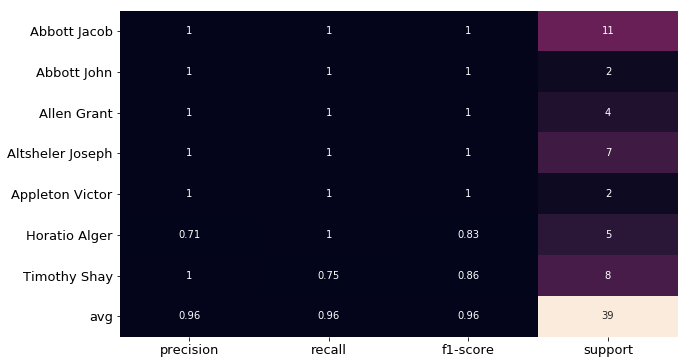

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=888)
rfc_model.fit(tfidf_train,y_train)
pr = rfc_model.predict(tfidf_test)
plot_classification_report(y_test, pr)

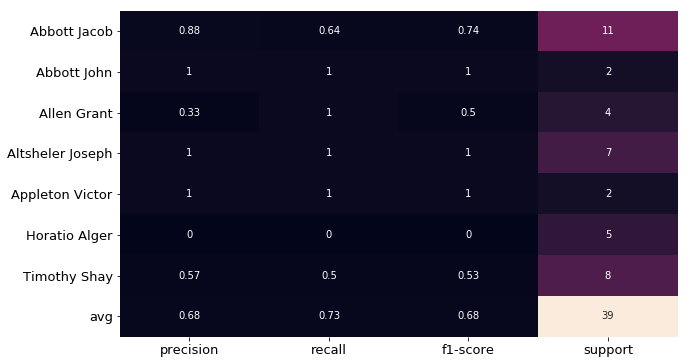

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
pr = gnb.fit(tfidf_train, y_train)
pr = gnb.predict(tfidf_test)
plot_classification_report(y_test, pr)

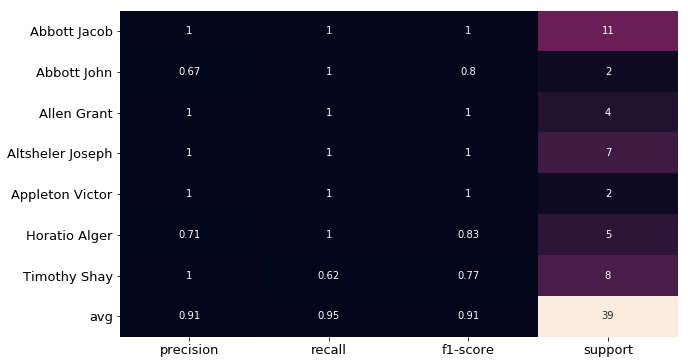

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1.5)
clf.fit(tfidf_train, y_train)
pr = clf.predict(tfidf_test)
plot_classification_report(y_test, pr)

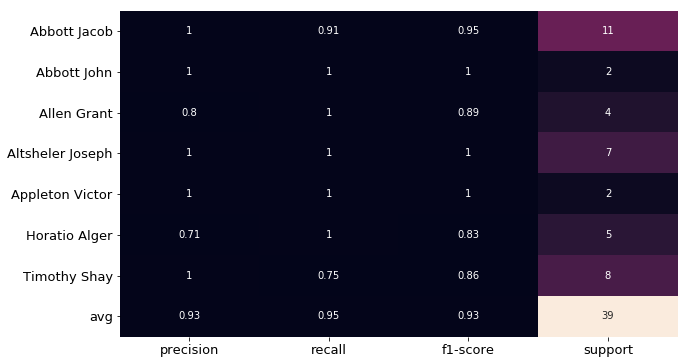

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=4)
clf.fit(tfidf_train, y_train)
pr = clf.predict(tfidf_test)
plot_classification_report(y_test, pr)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_trainenc = labelencoder_X.fit_transform(y_train)
y_testenc=labelencoder_X.transform(y_test)
from keras import utils as np_utils
y_train1h = np_utils.to_categorical(y_trainenc, 7)
y_test1h = np_utils.to_categorical(y_testenc, 7)

Using TensorFlow backend.


In [ ]:
# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

In [ ]:
import keras
model = Sequential()
    
model.add(Dense(512, activation='relu', input_dim=tfidf_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.RMSprop(),
             metrics=['accuracy'])
model.fit(tfidf_train, y_train1h,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(tfidf_test, y_test1h))
score = model.evaluate(tfidf_test, y_test1h, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 154 samples, validate on 39 samples
Epoch 1/10
154/154 [==============================] - 6s 37ms/step - loss: 1.9435 - acc: 0.1364 - val_loss: 1.8287 - val_acc: 0.2051
Epoch 2/10
154/154 [==============================] - 3s 18ms/step - loss: 1.8225 - acc: 0.2143 - val_loss: 1.5179 - val_acc: 0.5641
Epoch 3/10
154/154 [==============================] - 3s 17ms/step - loss: 1.5164 - acc: 0.4610 - val_loss: 2.1458 - val_acc: 0.2051
Epoch 4/10
154/154 [==============================] - 3s 17ms/step - loss: 1.5555 - acc: 0.4481 - val_loss: 1.0475 - val_acc: 0.6923
Epoch 5/10
154/154 [==============================] - 2s 15ms/step - loss: 0.6893 - acc: 0.9156 - val_loss: 0.5867 - val_acc: 0.9231
Epoch 6/10
154/154 [==============================] - 2s 15ms/step - loss: 0.2333 - acc: 0.9740 - val_loss: 0.6613 - val_acc: 0.7949
Epoch 7/10
154/154 [==============================] - 2s 16ms/step - loss: 0.4081 - acc: 0.7987 - val_loss: 0.4157 - val_acc: 0.9231
Epoch 8/10
154/154 [====

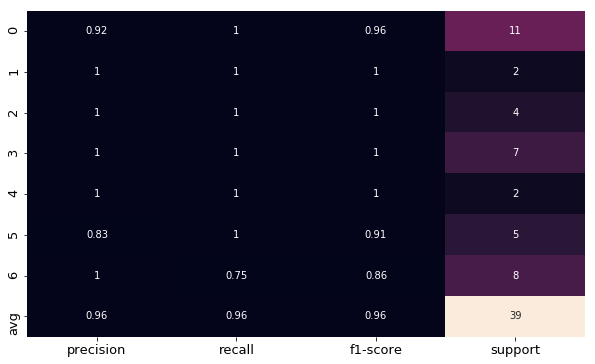

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict_classes(tfidf_test, batch_size = None)
plot_classification_report(y_testenc, y_predict)

####4. BAG OF WORD

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_vect.fit(data.text)
X_train_counts = count_vect.transform(X_train)
X_test_counts = count_vect.transform(X_test)
X_train_counts.shape

(154, 70411)

In [ ]:
print("training shape: {}{}".format(X_train_counts.shape,y_train.shape))
print("testing shape : {}{}".format(X_test_counts.shape,y_test.shape))

training shape: (154, 70411)(154,)
testing shape : (39, 70411)(39,)


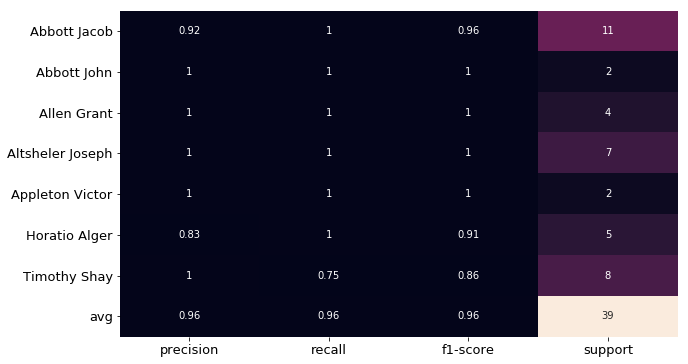

In [ ]:
rfc_model2 = RandomForestClassifier(n_estimators=100, random_state=888)
rfc_model2.fit(X_train_counts,y_train)
pr = rfc_model2.predict(X_test_counts)
plot_classification_report(y_test, pr)

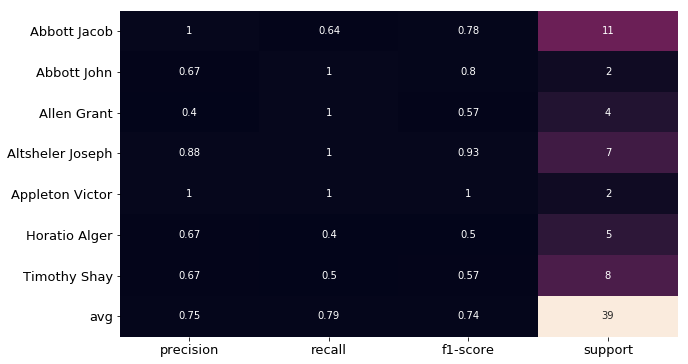

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
pr = gnb.fit(X_train_counts.toarray(), y_train)
pr = gnb.predict(X_test_counts.toarray())
plot_classification_report(y_test, pr)

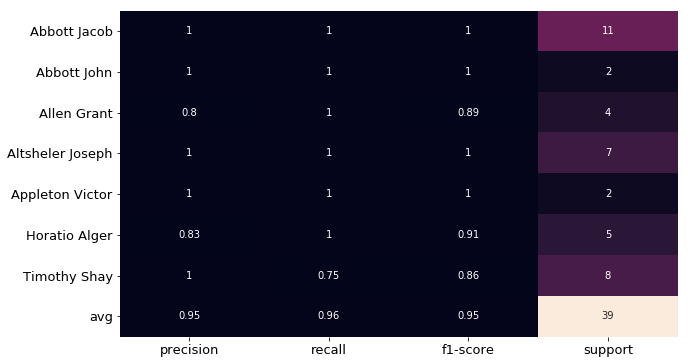

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1.5)
pr = clf.fit(X_train_counts.toarray(), y_train)
pr = clf.predict(X_test_counts.toarray())
plot_classification_report(y_test, pr)

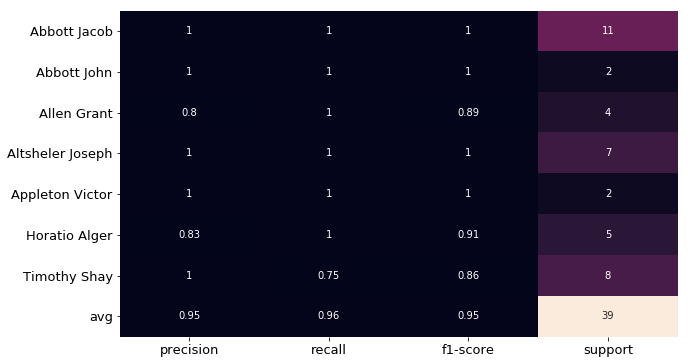

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=0.2)
pr = clf.fit(X_train_counts.toarray(), y_train)
pr = clf.predict(X_test_counts.toarray())
plot_classification_report(y_test, pr)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_counts.toarray())
X_train_counts_scale = scaler.transform(X_train_counts.toarray())
X_test_counts_scale = scaler.transform(X_test_counts.toarray())
model = Sequential()
    
model.add(Dense(512, activation='relu', input_dim=X_train_counts_scale.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.RMSprop(),
             metrics=['accuracy'])
model.fit(X_train_counts_scale, y_train1h,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(X_test_counts_scale, y_test1h))
score = model.evaluate(X_test_counts_scale, y_test1h, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\PhucCoi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.



Train on 154 samples, validate on 39 samples
Epoch 1/10
154/154 [==============================] - 5s 30ms/step - loss: 2.9372 - acc: 0.0974 - val_loss: 5.1037 - val_acc: 0.2051
Epoch 2/10
154/154 [==============================] - 3s 18ms/step - loss: 5.5035 - acc: 0.1883 - val_loss: 2.9461 - val_acc: 0.4103
Epoch 3/10
154/154 [==============================] - 3s 17ms/step - loss: 2.6901 - acc: 0.3377 - val_loss: 1.2635 - val_acc: 0.5385
Epoch 4/10
154/154 [==============================] - 3s 17ms/step - loss: 0.9241 - acc: 0.6883 - val_loss: 0.5117 - val_acc: 0.8974
Epoch 5/10
154/154 [==============================] - 3s 17ms/step - loss: 0.2157 - acc: 0.9481 - val_loss: 0.4931 - val_acc: 0.7949
Epoch 6/10
154/154 [==============================] - 3s 17ms/step - loss: 0.1635 - acc: 0.9416 - val_loss: 0.2707 - val_acc: 0.9487
Epoch 7/10
154/154 [==============================] - 3s 17ms/step - loss: 0.0274 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.9744
Epoch 8/10
154/154 [====

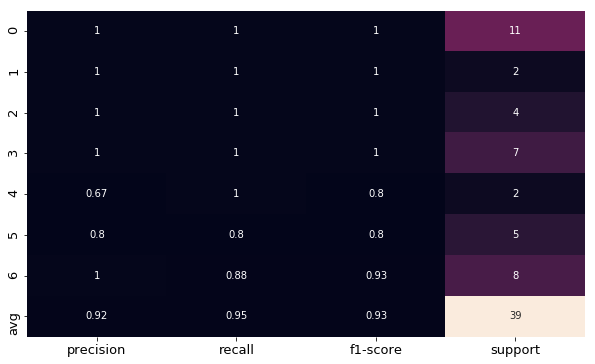

In [ ]:
from sklearn.metrics import classification_report
classes = model.predict_classes(X_test_counts_scale, batch_size = None)
plot_classification_report(y_testenc, classes)

####3. Word2Vec 

In [ ]:
from gensim.models.word2vec import Word2Vec
from gensim.models.ldamulticore import LdaMulticore
import re, itertools 
import nltk 
from nltk.corpus import stopwords

In [ ]:
data.head()

,author,title,text,sentence
0,Abbott Jacob,Alexander the Great,"﻿the project ebook, alexander the great, by ...","[﻿the project ebook, alexander the great, by ..."
1,Abbott Jacob,Bruno,"﻿the project ebook of bruno, by this ebook i...","[﻿the project ebook of bruno, by this ebook ..."
2,Abbott Jacob,Caleb in the Country,"﻿the project ebook, caleb in the country, by ...","[﻿the project ebook, caleb in the country, by ..."
3,Abbott Jacob,Charles I,"﻿the project ebook of charles i, by this ebo...","[﻿the project ebook of charles i, by this eb..."
4,Abbott Jacob,Cleopatra,"﻿the project ebook, cleopatra, by this eboo...","[﻿the project ebook, cleopatra, by this ebo..."


##### Removal special characters

In [ ]:
data.sentence[0][84]

'--philip attempt on his son'

In [ ]:
re.sub(r'[?|$|.|!|,|)|#|@|!|$|%|^|&|*|_|;|\|<|>|~|`|{|]|[|}|/|"|=|:|(|-]',r'','--@p&h{i*lip; a^tte$#mpt on !his) (so$n()')

'philip attempt on his son'

In [ ]:
removal_spec_char = lambda sense: re.sub(r'[?|$|.|!|,|)|#|@|!|$|%|^|&|*|_|;|\|<|>|~|`|{|]|[|}|/|"|=|:|(|-]',r'',sense)

In [ ]:
data.sentence = list(map(lambda sentences : list(map(removal_spec_char,sentences)),data.sentence))

##### Removal redundant spaces

In [ ]:
removal_redundant_space = lambda sense : re.sub(' +',' ',sense)

In [ ]:
data.sentence = list(map(lambda sentences : list(map(removal_redundant_space,sentences)),data.sentence))

In [ ]:
data.sentence[0][14]

'zip makers of history alexander the great by with engravings new york and london harper brothers publishers 1902 entered according to act of congress in the year one thousand eight hundred and fortynine by harper brothers in the clerk office of the district court of the southern district of new york'

In [ ]:
data.sentence[0][14]

'zip makers of history alexander the great by with engravings new york and london harper brothers publishers 1902 entered according to act of congress in the year one thousand eight hundred and fortynine by harper brothers in the clerk office of the district court of the southern district of new york'

#####  Lemmatization & Stemming 

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('wordnet')
lemm = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PhucCoi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
for idx, arr in enumerate(data.sentence):
    for idx1, sen in enumerate(arr):
        words = word_tokenize(sen)
        for _word in words:
            data.sentence[idx][idx1] = (data.sentence[idx][idx1]).replace(_word,lemm.lemmatize(_word))

In [ ]:
from nltk.stem import PorterStemmer
stemmer = nltk.stem.PorterStemmer()
ps = PorterStemmer()

In [ ]:
ps.stem('themselve') 

'themselv'

In [ ]:
ps.stem('suppose') 

'suppos'

##### Tokenization

In [ ]:
from nltk.tokenize import word_tokenize
tokens = word_tokenize(data.sentence[0][14])
print(tokens)

['zip', 'maker', 'of', 'history', 'alexander', 'the', 'great', 'by', 'with', 'engraving', 'new', 'york', 'and', 'london', 'harper', 'brother', 'publisher', '1902', 'entered', 'according', 'to', 'act', 'of', 'congress', 'in', 'the', 'year', 'one', 'thousand', 'eight', 'hundred', 'and', 'fortynine', 'by', 'harper', 'brother', 'in', 'the', 'clerk', 'office', 'of', 'the', 'district', 'court', 'of', 'the', 'southern', 'district', 'of', 'new', 'york']


In [ ]:
data.sentence = list(map(lambda sentences:list(map(nltk.word_tokenize, sentences)),data.sentence))  

In [ ]:
data.sentence = list(map(lambda sentences:list(filter(None, sentences)),data.sentence))  

In [ ]:
_input = []
[_input.extend(token) for token in data.sentence]

In [ ]:
_input[111]

['the',
 'persian',
 'had',
 'enormous',
 'army',
 'perfectly',
 'provided',
 'for',
 'with',
 'beautiful',
 'tent',
 'horse',
 'elegantly',
 'caparisoned',
 'arm',
 'and',
 'munition',
 'of',
 'war',
 'of',
 'the',
 'finest',
 'workmanship',
 'and',
 'officer',
 'magnificently',
 'dressed',
 'and',
 'accustomed',
 'to',
 'a',
 'life',
 'of',
 'luxury',
 'and',
 'splendor']

In [ ]:
print("Number of sentences: {}.".format(len(_input)))
print("Number of texts: {}.".format(len(data)))
size_dimention = 500  # Dimensionality of the word vectors.
sample = 1e-5   # The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).
W2Vmodel = Word2Vec(sentences=_input,
                    size=size_dimention,
                    sample=sample,
                    negative=10, # how many “noise words” should be drawn (usually between 5-20)
                    iter=5)

Number of sentences: 773538.
Number of texts: 193.


##### Similarity - related words

In [ ]:
W2Vmodel.wv.most_similar(positive='sleep', topn =3)

[('awake', 0.964647650718689),
 ('waited', 0.9500022530555725),
 ('tired', 0.9455375671386719)]

In [ ]:
W2Vmodel.wv.most_similar(positive='welcome', topn =3)

[('solemnly', 0.9617931842803955),
 ('halbert', 0.9616749286651611),
 ('reluctantly', 0.9601818323135376)]

##### Similarity - 2 words

In [ ]:
W2Vmodel.wv.similarity(w1='tired',w2='exhausted')

0.390012

In [ ]:
W2Vmodel.wv.similarity(w1='man',w2='boy')

0.697983

In [ ]:
W2Vmodel.wv.save_word2vec_format('model.bin')

In [ ]:
W2Vmodel.wv.save_word2vec_format('model.txt', binary=False)

In [ ]:
X = W2Vmodel[W2Vmodel.wv.vocab]

In [ ]:
X.shape

(31849, 500)

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [ ]:
words = list(W2Vmodel.wv.vocab)
pyplot.figure(figsize=(28,16))
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.savefig('w2v.png')

In [ ]:
# from gensim.models import Word2Vec
# from sklearn.decomposition import PCA
# from matplotlib import pyplot
# define training data
# sentences = [['the', 'history', 'of', 'the', 'life', 'of', 'every', 'individual', 'who', 'ha', 'for', 'any', 'reason', 'attracted', 'extensively', 'the', 'attention', 'of', 'mankind', 'ha', 'been', 'written', 'in', 'a', 'great', 'variety',
#  'of', 'way', 'by', 'a', 'multitude', 'of', 'author', 'and', 'person', 'sometimes', 'wonder', 'why', 'we', 'should', 'have', 'so', 'many', 'different', 'account',
#  'of', 'the', 'same', 'thing'],['among', 'the', 'twenty', 'million', 'of', 'people', 'in', 'the', 'united', 'state', 'there', 'are', 'perhaps',
#  'two', 'million', 'between', 'the', 'age', 'of', 'fifteen', 'and', 'twentyfive',
#  'who', 'wish', 'to', 'become', 'acquainted', 'in', 'general', 'with', 'the', 'leading', 'event', 'in', 'the', 'history', 'of', 'the', 'old', 'world', 'and', 'of', 'ancient', 'time', 'but', 'who', 'coming', 'upon', 'the', 'stage', 'in', 'this', 'land', 'and', 'at', 'this', 'period', 'have', 'idea', 'and', 'conception', 'so', 'widely', 'different', 'from', 'those', 'of', 'other', 'nation', 'and', 'of', 'other', 'time', 'that', 'a', 'mere', 'republication', 'of', 'existing',
#  'account', 'is', 'not', 'what', 'they', 'require']]
# train model
# model = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
# X = model[model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# create a scatter plot of the projection
# pyplot.figure(figsize=(15,6))
# pyplot.scatter(result[:, 0], result[:, 1])
# words = list(model.wv.vocab)
# for i, word in enumerate(words):
#     pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
# pyplot.show()

In [ ]:
df = pd.read_csv('.\Author Classification\model.txt', sep='\s+', index_col=0, header=None, skiprows=1).T
df.head(20)

,the,and,of,a,to,in,he,wa,it,i,...,ammy,mim,candyman,washboiler,mincepie,ruben,croome,mamlet,postnotes,bettina
1,-0.058613,0.015442,-0.158179,0.140175,0.093452,0.018156,0.119811,0.044857,0.351965,0.480889,...,0.036848,0.060897,0.072883,0.040233,0.048775,0.059252,0.029014,0.047536,0.034878,0.043068
2,-0.167606,-0.107773,-0.029066,-0.206769,-0.091758,-0.089092,-0.154339,-0.113168,-0.195455,-0.007680,...,-0.008903,-0.024123,-0.023799,-0.013842,-0.015706,-0.023821,-0.014749,-0.013498,-0.011608,-0.019654
3,0.050763,-0.017081,-0.124401,0.155085,0.175548,-0.029413,0.246189,0.039933,0.143591,0.205823,...,0.002832,0.014112,0.011426,0.006556,0.012816,0.004323,-0.006120,0.006841,0.008062,0.006986
4,0.283456,0.208988,0.110836,-0.007077,0.265104,0.023497,-0.027724,-0.074092,0.075550,-0.089214,...,0.003451,0.012912,0.016158,0.011206,0.010511,0.012700,0.006781,0.007779,0.008678,0.016355
5,0.152869,-0.006580,-0.009774,0.116188,0.039773,0.047682,0.008068,-0.107139,0.040009,-0.013390,...,-0.000931,-0.006203,0.000539,-0.003435,-0.003693,-0.003387,-0.002963,-0.003910,-0.001301,-0.003683
6,-0.303850,-0.240901,-0.141896,-0.353064,-0.236885,-0.251803,-0.135014,-0.171172,-0.240512,-0.066822,...,-0.017229,-0.034056,-0.035705,-0.034550,-0.028613,-0.038040,-0.018091,-0.030413,-0.033564,-0.027356
7,-0.060181,-0.018076,-0.095351,0.063036,0.152779,-0.043313,0.204786,0.116359,0.238132,0.519161,...,0.034326,0.054077,0.054955,0.037770,0.042445,0.055588,0.021609,0.046166,0.026153,0.034271
8,-0.018450,0.055413,0.150328,-0.057409,0.122050,0.004888,0.025636,0.120896,0.028930,-0.081630,...,0.013735,0.023155,0.025410,0.019518,0.019151,0.035002,0.024967,0.015244,0.024142,0.023824
9,0.150711,-0.045342,0.113541,0.078095,-0.092342,0.082688,0.048401,0.212850,-0.003304,-0.105927,...,0.013470,0.031545,0.030628,0.021006,0.022784,0.024101,0.013085,0.021289,0.009966,0.025659
10,-0.152842,0.002193,-0.028607,-0.103305,-0.122894,-0.142592,-0.069936,-0.051416,-0.089264,-0.050450,...,0.009329,0.018636,0.020544,0.014005,0.011381,0.016537,0.010887,0.011519,0.016735,0.015162


In [ ]:
import re
def untokenize(words):
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

In [ ]:
data.sentence = list(map(lambda sentences:list(map(untokenize, sentences)),data.sentence))  

In [ ]:
data.sentence[0]
[['\ufeffthe',
  'project',
  'ebook',
  'alexander',
  'the',
  'great',
  'by',
  'this',
  'ebook',
  'is',
  'for',
  'the',
  'use',
  'of',
  'anyone',
  'anywhere',
  'at',
  'no',
  'cost',
  'and',
  'with',
  'almost',
  'no',
  'restriction',
  'whatsoever'],

In [ ]:
#https://github.com/bluelight773/Kaggle_IMDB_Bags_of_Popcorn
from bs4 import BeautifulSoup
def html_to_text(html):
    """Return extracted text string from provided HTML string."""
    text = BeautifulSoup(html.strip(), "lxml")
    text = " ".join(text.strings)  # One may/not need to use strip()
    return html

def text_to_wordlist(text, get_text_from_html=False, letters_only=True, lowercase=True, remove_stopwords=False):
    """Convert text to a sequence of words with the specified preprocessing applied.
    Returns a list of words.
    """

    # 1. Remove HTML
    # review_text = BeautifulSoup(review).get_text()
    if get_text_from_html:
        text = html_to_text(text)

    # 2. Remove non-letters
    if letters_only:
        text = letters_only(text)

    # 3. Convert words to lower case and split them
    if lowercase:
        text = text.lower()

    words = text.split()

    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        words = [w for w in words if w not in stop_words]

    # 5. Return a list of words
    return(words)


# -1 accounts for first row being run twice when map is used (by design)
reviews_converted_to_sentences = -1
def get_w2v_features(review, get_text_from_html=True, letters_only=True, lowercase=True, remove_stopwords=True,
                     num_features=300):
    """Average all of the word vectors in the provided review after pre-processing it according to the parameter values.
    Based on https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-3-more-fun-with-word-vectors
    """
    global stop_words, reviews_done, w2v_model, index2word_set

    # Note that one would expect appropriate and consistent preprocessing should be before feeding data for training w2v
    # model and before attempting to get w2v features.  However, empirical verification is the only way to know for sure
    # (eg when may be better off removing stopwords even if Google News model includes them)
    words = text_to_wordlist(review, get_text_from_html=get_text_from_html, letters_only=letters_only,
                             lowercase=lowercase,
                             remove_stopwords=remove_stopwords)

    # Pre-initialize an empty numpy array (for speed)
    # All-zeros will be what's returned if none of the words are in the w2v model
    feature_vec = np.zeros((num_features,), dtype="float32")
    nwords = 0.

    # Loop over each word in the review and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec, w2v_model[word])

    # Divide the result by the number of words to get the average
    feature_vec = np.divide(feature_vec, nwords)

    reviews_done += 1
    if reviews_done % 500 == 0:
        print("Word2Vec features extracted for {} reviews".format(reviews_done))

    return feature_vec

In [ ]:
data['w2v_features'] = list(map(lambda senten:get_w2v_features(W2Vmodel, senten),data.sentence))

In [ ]:
data.head()

,author,title,text,sentence,w2v_features
0,Abbott Jacob,Alexander the Great,"﻿the project ebook, alexander the great, by ...","[[﻿the, project, ebook, alexander, the, great,...","[0.09259578, 0.10967822, -0.032081384, -0.0046..."
1,Abbott Jacob,Bruno,"﻿the project ebook of bruno, by this ebook i...","[[﻿the, project, ebook, of, bruno, by, this, e...","[0.074832514, 0.08163656, -0.034389686, 0.0222..."
2,Abbott Jacob,Caleb in the Country,"﻿the project ebook, caleb in the country, by ...","[[﻿the, project, ebook, caleb, in, the, countr...","[0.057736956, 0.06581772, -0.018010892, 0.0313..."
3,Abbott Jacob,Charles I,"﻿the project ebook of charles i, by this ebo...","[[﻿the, project, ebook, of, charles, i, by, th...","[0.072724104, 0.088323265, -0.026417933, -0.00..."
4,Abbott Jacob,Cleopatra,"﻿the project ebook, cleopatra, by this eboo...","[[﻿the, project, ebook, cleopatra, by, this, e...","[0.08771339, 0.10481417, -0.024504583, -0.0048..."


In [ ]:
data.to_csv('.\\Author Classification\\fulldataframe.csv')

In [ ]:
# W2Vmodel.wv.save_word2vec_format('W2Vmodel.bin', binary=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.w2v_features, data.author, test_size=0.2, random_state=12)

In [ ]:
print("training shape: {}{}".format(X_train.shape,y_train.shape))
print("testing shape : {}{}".format(X_test.shape,y_test.shape))

training shape: (154,)(154,)
testing shape : (39,)(39,)


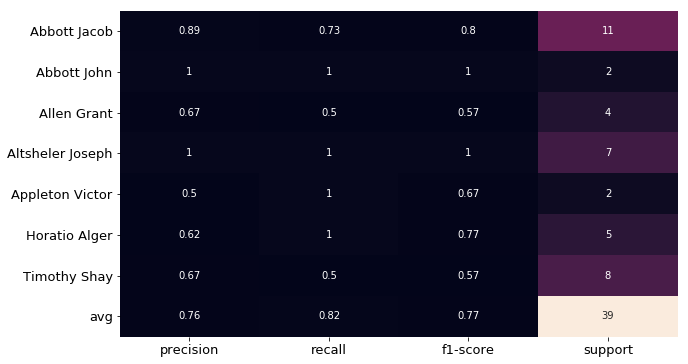

In [ ]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=888)
rfc_model.fit(np.array(list(map(np.array, X_train))),y_train)
pr = rfc_model.predict(np.array(list(map(np.array, X_test))))
plot_classification_report(y_test, pr)

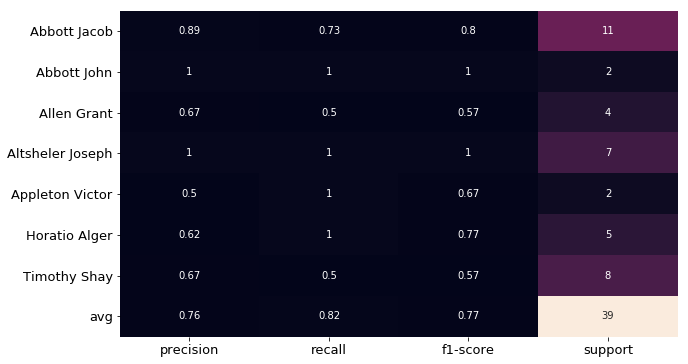

In [ ]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1.5)
clf.fit(np.array(list(map(np.array, X_train))),y_train)
pr = rfc_model.predict(np.array(list(map(np.array, X_test))))
plot_classification_report(y_test, pr)

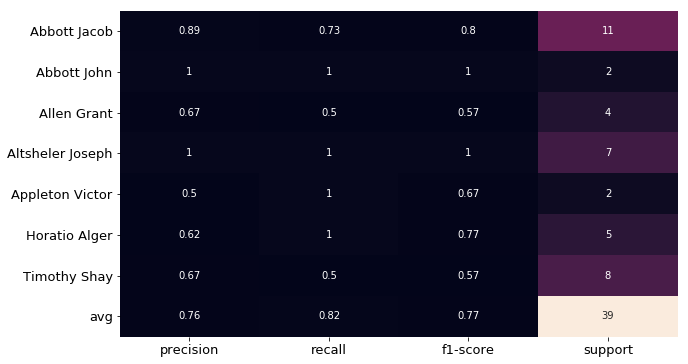

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=4)
clf.fit(np.array(list(map(np.array, X_train))),y_train)
pr = rfc_model.predict(np.array(list(map(np.array, X_test))))
plot_classification_report(y_test, pr)

In [ ]:
from sklearn.model_selection import train_test_split
# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(data.w2v_features, data.author, test_size=0.2, random_state=12)

Train on 154 samples, validate on 39 samples
Epoch 1/10
154/154 [==============================] - 2s 12ms/step - loss: 1.9712 - acc: 0.1234 - val_loss: 1.9409 - val_acc: 0.0513
Epoch 2/10
154/154 [==============================] - 0s 715us/step - loss: 1.9623 - acc: 0.1688 - val_loss: 1.9166 - val_acc: 0.2051
Epoch 3/10
154/154 [==============================] - 0s 715us/step - loss: 1.9289 - acc: 0.1883 - val_loss: 1.9245 - val_acc: 0.1282
Epoch 4/10
154/154 [==============================] - 0s 780us/step - loss: 1.8812 - acc: 0.1623 - val_loss: 1.8440 - val_acc: 0.2308
Epoch 5/10
154/154 [==============================] - 0s 715us/step - loss: 1.7976 - acc: 0.2078 - val_loss: 2.6233 - val_acc: 0.1795
Epoch 6/10
154/154 [==============================] - 0s 734us/step - loss: 2.2856 - acc: 0.1623 - val_loss: 1.8435 - val_acc: 0.2821
Epoch 7/10
154/154 [==============================] - 0s 747us/step - loss: 1.8039 - acc: 0.2662 - val_loss: 1.7964 - val_acc: 0.1795
Epoch 8/10
154/154

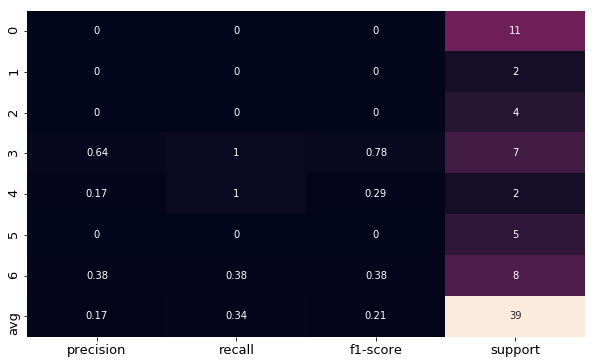

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_trainenc = labelencoder_X.fit_transform(y_train)
y_testenc=labelencoder_X.transform(y_test)
from keras import utils as np_utils
y_train_ = np_utils.to_categorical(y_trainenc, 7)
y_test_ = np_utils.to_categorical(y_testenc, 7)

import keras
model = Sequential()
    
model.add(Dense(512, activation='relu', input_dim=np.array(list(map(np.array, X_train))).shape[1]))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(7, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = keras.optimizers.RMSprop(),
             metrics=['accuracy'])
model.fit(np.array(list(map(np.array, X_train))), y_train_,
        batch_size=128,
        epochs=10,
        verbose=1,
        validation_data=(np.array(list(map(np.array, X_test))), y_test_))
score = model.evaluate(np.array(list(map(np.array, X_test))), y_test_, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
from sklearn.metrics import classification_report
y_predict = model.predict_classes(np.array(list(map(np.array, X_test))), batch_size = None)
plot_classification_report(y_testenc, y_predict)

#### LDA

In [ ]:
data.sentence[0]
[['\ufeffthe',
  'project',
  'ebook',
  'alexander',
  'the',
  'great',
  'by',
  'this',
  'ebook',
  'is',
  'for',
  'the',
  'use',

In [ ]:
import re
def untokenize(words):
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

In [ ]:
data['untokenize']= list(map(lambda sentences:list(map(untokenize, sentences)),data.sentence))  

In [ ]:
data.head()

,author,title,text,sentence,w2v_features,untokenize
0,Abbott Jacob,Alexander the Great,"﻿the project ebook, alexander the great, by ...","[[﻿the, project, ebook, alexander, the, great,...","[0.080672875, -0.058291655, 0.0072988723, 0.10...",[﻿the project ebook alexander the great by thi...
1,Abbott Jacob,Bruno,"﻿the project ebook of bruno, by this ebook i...","[[﻿the, project, ebook, of, bruno, by, this, e...","[0.14818683, -0.059004176, 0.06520473, 0.08157...",[﻿the project ebook of bruno by this ebook is ...
2,Abbott Jacob,Caleb in the Country,"﻿the project ebook, caleb in the country, by ...","[[﻿the, project, ebook, caleb, in, the, countr...","[0.17535397, -0.05653682, 0.0731933, 0.0876790...",[﻿the project ebook caleb in the country by th...
3,Abbott Jacob,Charles I,"﻿the project ebook of charles i, by this ebo...","[[﻿the, project, ebook, of, charles, i, by, th...","[0.08831859, -0.04906485, 0.009179941, 0.09389...",[﻿the project ebook of charles i by this ebook...
4,Abbott Jacob,Cleopatra,"﻿the project ebook, cleopatra, by this eboo...","[[﻿the, project, ebook, cleopatra, by, this, e...","[0.0796483, -0.05462291, 0.0011151998, 0.10026...",[﻿the project ebook cleopatra by this ebook is...


##### Cleaning and Preprocessing


In [ ]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in data.text] 

In [ ]:
len(doc_clean)

193

##### Preparing Document-Term Matrix


In [ ]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
len(dictionary)

115110

In [ ]:
len(doc_term_matrix)

193

In [ ]:
doc_term_matrix[0] 
'''
[(0, 3),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
'''

##### Running LDA Model


In [ ]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=50)

In [ ]:
ldamodel.alpha

array([0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
       0.14285715, 0.14285715], dtype=float32)

In [ ]:
ldamodel.print_topics(num_topics=10, num_words=3)

[(0, '0.010*"said" + 0.006*"would" + 0.006*"it"'),
 (1, '0.006*"one" + 0.006*"work" + 0.004*"great"'),
 (2, '0.013*"mr" + 0.010*"said" + 0.006*"one"'),
 (3, '0.006*"upon" + 0.006*"king" + 0.006*"one"'),
 (4, '0.014*"said" + 0.012*"mr" + 0.010*"tom"'),
 (5, '0.011*"said" + 0.009*"ned" + 0.008*"it"'),
 (6, '0.006*"one" + 0.006*"it" + 0.005*"said"')]

In [ ]:
ldamodel.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  '0.010*"said" + 0.006*"would" + 0.006*"it" + 0.006*"one" + 0.006*"great" + 0.005*"could" + 0.004*"henry" + 0.004*"long" + 0.004*"men" + 0.004*"him"'),
 (1,
  '0.006*"one" + 0.006*"work" + 0.004*"great" + 0.004*"frederick" + 0.003*"may" + 0.003*"life" + 0.003*"first" + 0.003*"upon" + 0.003*"st" + 0.003*"time"'),
 (2,
  '0.013*"mr" + 0.010*"said" + 0.006*"one" + 0.006*"would" + 0.006*"upon" + 0.005*"i" + 0.005*"it" + 0.004*"time" + 0.004*"child" + 0.004*"man"'),
 (3,
  '0.006*"upon" + 0.006*"king" + 0.006*"one" + 0.005*"would" + 0.004*"time" + 0.004*"could" + 0.004*"great" + 0.003*"day" + 0.003*"him" + 0.003*"men"'),
 (4,
  '0.014*"said" + 0.012*"mr" + 0.010*"tom" + 0.008*"i" + 0.007*"it" + 0.007*"you" + 0.006*"“i" + 0.006*"would" + 0.005*"one" + 0.005*"boy"'),
 (5,
  '0.011*"said" + 0.009*"ned" + 0.008*"it" + 0.008*"one" + 0.006*"work" + 0.006*"go" + 0.006*"well" + 0.005*"get" + 0.005*"could" + 0.005*"would"'),
 (6,
  '0.006*"one" + 0.006*"it" + 0.005*"said" + 0.005*"man" + 0.004

In [ ]:
import pandas as pd

top_words_per_topic = []
for t in range(ldamodel.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamodel.show_topic(t, topn = 5)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")

In [ ]:
lda_df = pd.read_csv('top_words.csv',index_col=0)

In [ ]:
lda_df.shape

(35, 3)

In [ ]:
lda_df.Topic.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [ ]:
lda_df.head(15)

,Topic,Word,P
0,0,said,0.009957
1,0,would,0.006188
2,0,it,0.005975
3,0,one,0.005758
4,0,great,0.005531
5,1,one,0.005586
6,1,work,0.005542
7,1,great,0.004263
8,1,frederick,0.003753
9,1,may,0.003139


In [ ]:
import pyLDAvis.gensim
import pyLDAvis

In [ ]:
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
corpus =  [dictionary.doc2bow(doc) for doc in doc_clean]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_display3 = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

In [ ]:
pyLDAvis.save_html(fileobj='pyLDAvis.html',data=lda_display3)

Saliency: a measure of how much the term tells you about the topic.

Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

# Non-negative matrix factorization

In [ ]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(data.text)

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names()


Topics in NMF model:


In [ ]:
from time import time
from sklearn.decomposition import NMF

t1 = time()
nmf = NMF(n_components=7, random_state=1,
          alpha=.1, l1_ratio=.5)
nnf_model = nmf.fit(tf)
print("Done in %0.3fs." % (time() - t1))

Done in 1.833s.


In [ ]:
len(nmf.components_)

7

In [ ]:
nmf.components_

array([[2.20171331e-01, 2.13856817e-03, 2.13856817e-03, ...,
        0.00000000e+00, 3.08993175e-03, 0.00000000e+00],
       [9.38970273e-01, 0.00000000e+00, 0.00000000e+00, ...,
        3.50038015e-03, 1.92019028e-04, 1.26556681e-02],
       [0.00000000e+00, 4.56631458e-04, 4.56631458e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 6.06228951e-04, 6.06228951e-04, ...,
        1.00332284e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.30145305e-04, 1.30145305e-04, ...,
        1.68020045e-03, 0.00000000e+00, 1.18631978e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.37248645e-04]])

In [ ]:
nmf.components_[0]

array([0.22017133, 0.00213857, 0.00213857, ..., 0.        , 0.00308993,
       0.        ])

In [ ]:
nmf.components_[0].argsort()

array([35671, 11728, 11714, ..., 10747, 10792, 21352], dtype=int64)

In [ ]:
tf_feature_names[10747]

'dollar'

In [ ]:
message = "Topic # {}: ".format(0)
message += " ".join([tf_feature_names[i] for i in nmf.components_[0].argsort()[:-1000 - 1 :-1]])
message

'Topic # 0: mr dont dollar answered woman sir wife oh lady husband girl love dear rollo im street miss harley family uncle chapter gentleman wont george didnt mary herbert son frank grayson doctor spoke table don till andy afraid exclaimed ive smile lip hotel york store ernest sister thank spirit brother daughter round self nature bad beautiful hardly isnt god happy deal rich markland pleasant chance pocket window quickly town school cent aunt boat talk cried expression dinner wouldnt tear carriage circumstance sick captain cold stranger sum picture chair companion evil stay morrow chester getting floor edith heaven society desire wine fanny phil dan sorry glass past squire age ah ll board regard oclock wanted inquired oliver ben soul death later afternoon pain james jasper pale ago quiet helen prescott bear fortune drink conversation countenance dexter dead willing ear price write mountain grit sharp common natural body started dick sad chamber servant edward le silence likely youre a

In [ ]:
_doc=[]
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic # {}:\n".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        _doc.append(message)
        print(message)
        print("="*160)
print_top_words(nmf, tf_feature_names, 200)


Topic # 0:
mr dont dollar answered woman sir wife oh lady husband girl love dear rollo im street miss harley family uncle chapter gentleman wont george didnt mary herbert son frank grayson doctor spoke table don till andy afraid exclaimed ive smile lip hotel york store ernest sister thank spirit brother daughter round self nature bad beautiful hardly isnt god happy deal rich markland pleasant chance pocket window quickly town school cent aunt boat talk cried expression dinner wouldnt tear carriage circumstance sick captain cold stranger sum picture chair companion evil stay morrow chester getting floor edith heaven society desire wine fanny phil dan sorry glass past squire age ah ll board regard oclock wanted inquired oliver ben soul death later afternoon pain james jasper pale ago quiet helen prescott bear fortune drink conversation countenance dexter dead willing ear price write mountain grit sharp common natural body started dick sad chamber servant edward le silence likely youre a